# **Ф35**: Модуль прогнозирования эффектов трансформации территории в масштабах населенного пункта и региона

## 1. Подготовка исходных данных

- `service_types` -- таблица типов сервисов.
- `blocks` -- слой городских кварталов с разной информацией.
- `acc_mx` -- матрица доступности городских кварталов.

In [1]:
import pandas as pd
import geopandas as gpd
from blocksnet.config import log_config

log_config.set_disable_tqdm(True)
log_config.set_logger_level('ERROR')

service_types = pd.read_pickle('./data/service_types.pickle')
blocks = pd.read_pickle('./data/blocks.pickle')
acc_mx = pd.read_pickle('./data/acc_mx.pickle')

In [2]:
blocks['population'] = blocks['population'].fillna(0)

### 1.1. Подготовка списка сервисов

Нужны только те списки сервисов, у которых есть `infrastructure_type`

In [3]:
service_types = service_types[~service_types['infrastructure_type'].isna()].copy()
service_types.head()

,name,infrastructure_type,infrastructure_weight,social_values
service_type_id,,,,
1,park,basic,0.2,[8]
5,beach,comfort,0.5,None
21,kindergarten,basic,0.2,[2]
22,school,basic,0.2,"[2, 4]"
27,university,comfort,0.2,"[4, 10, 17]"


## 2A. Эффекты ДО

Если `scenario_id` является `base_scenario`, то мы не обязаны ничего оптимизировать и просто должны посчитать обеспеченность as is.

In [4]:
from blocksnet.relations.accessibility import get_accessibility_context

def _get_accessibility_context(blocks : pd.DataFrame, acc_mx : pd.DataFrame, accessibility : float) -> list[int]:
  project_blocks = blocks[blocks['is_project']].copy()
  context_blocks = get_accessibility_context(acc_mx, project_blocks, accessibility, out=False, keep=True)
  return list(context_blocks.index)

In [5]:
from blocksnet.analysis.provision import competitive_provision
from blocksnet.config import service_types_config

def _assess_provision(blocks : pd.DataFrame, acc_mx : pd.DataFrame, service_type : str) -> gpd.GeoDataFrame:
  _, demand, accessibility = service_types_config[service_type].values()
  context_ids = _get_accessibility_context(blocks, acc_mx, accessibility)
  capacity_column = f'capacity_{service_type}'
  if capacity_column not in blocks.columns:
    blocks_df = blocks[['geometry','population']].fillna(0)
    blocks_df['capacity'] = 0
  else:
    blocks_df = blocks.rename(columns={capacity_column:'capacity'})[['geometry', 'population', 'capacity']].fillna(0)
  prov_df, _ = competitive_provision(blocks_df, acc_mx, accessibility, demand)
  prov_df = prov_df.loc[context_ids].copy()
  return blocks[['geometry']].join(prov_df, how='right')

### Получаем слои с оценкой обеспеченности

In [6]:
from blocksnet.config import service_types_config

prov_gdfs = {}
for st_id in service_types.index:
    st_name = service_types.loc[st_id,'name']
    column = f'capacity_{st_name}'
    _,demand,accessibility = service_types_config[st_name].values()
    prov_gdf = _assess_provision(blocks, acc_mx, st_name)
    prov_gdfs[st_name] = prov_gdf

Например:

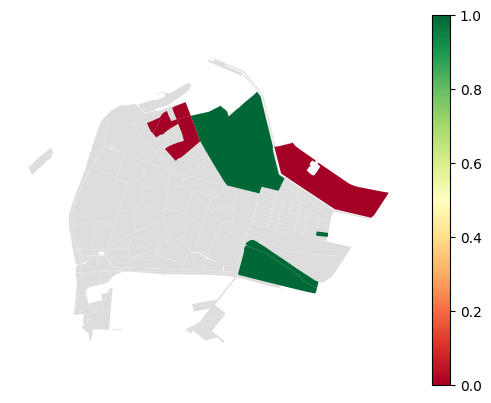

In [7]:
ax = prov_gdfs['school'].plot(color='#ddd')
prov_gdfs['school'].plot('provision_strong', ax=ax, vmin=0, vmax=1, cmap='RdYlGn', legend=True).set_axis_off()

### Получаем общие оценки обеспеченности

In [19]:
from blocksnet.analysis.provision import provision_strong_total

prov_totals_before = {}
for st_name, prov_gdf in prov_gdfs.items():
    if prov_gdf.demand.sum() == 0:
        total = None
    else:
        total = float(provision_strong_total(prov_gdf))
    prov_totals_before[st_name] = total

В итоге:

In [20]:
prov_totals_before

{'park': 1.0,
 'beach': 0.0,
 'kindergarten': 0.0,
 'school': 0.674074074074074,
 'university': 0.0,
 'polyclinic': 0.0,
 'pharmacy': 1.0,
 'hospital': 0.5707547169811321,
 'library': 1.0,
 'museum': 0.9856115107913669,
 'theatre': 0.0,
 'cinema': 0.0,
 'mall': 0.8875,
 'stadium': 0.19327731092436976,
 'cafe': 1.0,
 'restaurant': 0.6990838618745595,
 'bar': 0.4642857142857143,
 'pitch': 1.0,
 'playground': None,
 'police': 0.4,
 'train_station': 0.3865546218487395,
 'supermarket': 0.9897209985315712,
 'market': 0.6977599465061852,
 'bank': 1.0,
 'veterinary': 0.711864406779661,
 'hotel': 1.0,
 'religion': 0.6984924623115578,
 'sanatorium': 0.0}

### Результат

В результате имеем следующие данные для ситуации ДО:
- `prov_gdfs : dict[str, gpd.GeoDataFrame]` -- слои с оценкой обеспеченности по выбранным типам сервисов
- `prov_totals : dict[str, float | None]` -- оценки обеспеченности

## 2B. Эффекты ПОСЛЕ

Если `scenario_id` не является `base_scenario`, то для заданного пользователем функционального зонирования мы должны предсказать возможную обеспеченность (по сути, лучший случай).

### Подготовка данных

Для каждого `infrastructure_type` также добавим весовой коэффициент, чтобы отдать предпочтение базовым сервисам, а остальные добавлять по возможности.

In [21]:
INFRASTRUCTURES_WEIGHTS = {
    'basic': 0.5714,
    'additional': 0.2857,
    'comfort': 0.1429
}

service_types['infrastructure_weight'] = service_types['infrastructure_type'].map(INFRASTRUCTURES_WEIGHTS) * service_types['infrastructure_weight']
service_types.head()

,name,infrastructure_type,infrastructure_weight,social_values
service_type_id,,,,
1,park,basic,0.065300,[8]
5,beach,comfort,0.010210,None
21,kindergarten,basic,0.065300,[2]
22,school,basic,0.065300,"[2, 4]"
27,university,comfort,0.004084,"[4, 10, 17]"


Готовим словарь, какой квартал в какой ФЗ переводим.

`blocks_lus : dict[int, LandUse]`

In [22]:
blocks_lus = blocks.loc[blocks['is_project'],'land_use']
blocks_lus = blocks_lus[~blocks_lus.isna()]
blocks_lus = blocks_lus.to_dict()

Инициализируем экземпляр класса оптимизатора.

In [23]:
from blocksnet.optimization.services import (
    TPEOptimizer,
    WeightedObjective,
    WeightedConstraints,
    Facade,
    BlockSolution,
    GradientChooser,
    AreaSolution
)

var_adapter = AreaSolution(blocks_lus)

facade = Facade(
    blocks_lu=blocks_lus,
    blocks_df=blocks,
    accessibility_matrix=acc_mx,
    var_adapter=var_adapter,
)


Добавляем информацию о существующих типах сервисов.

**ВАЖНО**: если сервиса нет в слое кварталов, просто добавляем `DataFrame` с нулевыми `capacity` для него. Ведь мы же должны что-то расставлять.

ЛИБО

Можно попробовать на этапе сборки слоя просто добавлять пустой столбец, чтобы не терять.

In [24]:
for st_id, row in service_types.iterrows():
    st_name = row['name']
    st_weight = row['infrastructure_weight']
    st_column = f'capacity_{st_name}'
    if st_column in blocks.columns:
        df = blocks.rename(columns={st_column: 'capacity'})[['capacity']].fillna(0)
    else:
        print(f'#{st_id}:{st_name} нет на территории контекста проекта. Добавляем нулевой датафрейм')
        df = blocks[[]].copy()
        df['capacity'] = 0
    facade.add_service_type(st_name, st_weight, df)

#5:beach нет на территории контекста проекта. Добавляем нулевой датафрейм
#51:theatre нет на территории контекста проекта. Добавляем нулевой датафрейм
#56:cinema нет на территории контекста проекта. Добавляем нулевой датафрейм
#143:sanatorium нет на территории контекста проекта. Добавляем нулевой датафрейм


### Оптимизация

Запускаем оптимизатор...

In [ ]:
MAX_EVALS = 1000 # сколько раз будет считаться обеспеченность. Можно ставить и большее число, если ориентируемся только на время
MAX_RUNS = 1000 # сколько итераций будет считаться в оптимизации. Так же ставим 1000 без проблем
TIMEOUT = 1 * 60 # сколько по времени будет считаться оптимизация (в секундах). Если уже прошло данное время, досчитается итерация и отдаст ответ

In [28]:
services_weights = service_types.set_index('name')['infrastructure_weight'].to_dict()

objective = WeightedObjective(num_params=facade.num_params, facade=facade, weights=services_weights, max_evals=MAX_EVALS)

constraints = WeightedConstraints(num_params=facade.num_params, facade=facade)

tpe_optimizer = TPEOptimizer(
    objective=objective, constraints=constraints, vars_chooser=GradientChooser(facade, facade.num_params, num_top=5)
)

best_x, best_val, perc, func_evals = tpe_optimizer.run(max_runs=MAX_RUNS, timeout=TIMEOUT, initial_runs_num=1)

[I 2025-09-26 01:54:17,133] A new study created in memory with name: no-name-7bcf0f9c-68c1-4c7b-9992-0933b7507291


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-09-26 01:54:22,560] Trial 0 finished with value: 0.7201585159559923 and parameters: {'x_0': 12000, 'x_1': 12000, 'x_2': 12000, 'x_3': 12000, 'x_4': 12000, 'x_5': 12000, 'x_6': 12000, 'x_7': 0, 'x_8': 12000, 'x_9': 1440, 'x_10': 1440, 'x_11': 1440, 'x_12': 1440, 'x_13': 1440, 'x_14': 1440, 'x_15': 1440, 'x_16': 1440, 'x_17': 1440, 'x_18': 3520, 'x_19': 3520, 'x_20': 0, 'x_21': 3520, 'x_22': 3520, 'x_23': 3520, 'x_24': 3520, 'x_25': 3520, 'x_26': 3520, 'x_27': 0, 'x_28': 3520, 'x_29': 3520, 'x_30': 3520, 'x_31': 0, 'x_32': 0, 'x_33': 0, 'x_34': 0, 'x_35': 18500, 'x_36': 18500, 'x_37': 0, 'x_38': 18500, 'x_39': 18500, 'x_40': 18500, 'x_41': 18500, 'x_42': 18500, 'x_43': 18500, 'x_44': 0, 'x_45': 18500, 'x_46': 18500, 'x_47': 18500, 'x_48': 0, 'x_49': 0, 'x_50': 0, 'x_51': 0, 'x_52': 20000, 'x_53': 30000, 'x_54': 0, 'x_55': 0, 'x_56': 30000, 'x_57': 30000, 'x_58': 30000, 'x_59': 30000, 'x_60': 30000, 'x_61': 20000, 'x_62': 20000, 'x_63': 30000, 'x_64': 30000, 'x_65': 20000, 'x_66':

### Результат

Если для данного типа сервиса все хорошо в плане обеспеченности с самого начала, то он не оптимизируется и для него обеспеченность считается той же, что и раньше.

In [29]:
prov_gdfs = {}
for st_id in service_types.index:
    st_name = service_types.loc[st_id, 'name']
    if st_name in facade._chosen_service_types:
        prov_df = facade._provision_adapter.get_last_provision_df(st_name)
        prov_gdf = blocks[['geometry']].join(prov_df, how='right')
        prov_gdfs[st_name] = prov_gdf

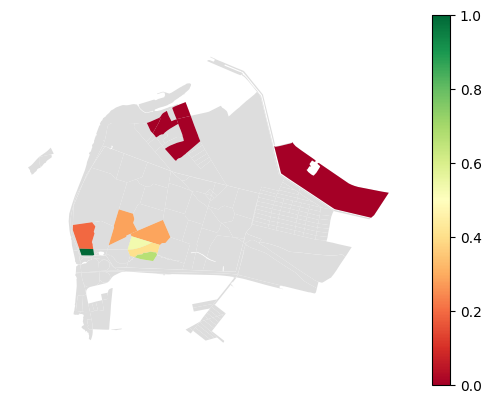

In [30]:
ax = prov_gdfs['school'].plot(color='#ddd')
prov_gdfs['school'].plot('provision_strong', ax=ax, vmin=0, vmax=1, cmap='RdYlGn', legend=True).set_axis_off()

Чиселки обеспеченности для графика

In [31]:
prov_totals_after = {}
for st_name, prov_gdf in prov_gdfs.items():
    if prov_gdf.demand.sum() == 0:
        total = None
    else:
        total = float(provision_strong_total(prov_gdf))
    prov_totals_after[st_name] = total

Если какой-то сервис тут отсутствует, можно брать с `base_scenario` (?? я подумаю еще правильно ли это)

In [32]:
prov_totals_after

{'park': 1.0,
 'beach': 1.0,
 'kindergarten': 0.16489988221436985,
 'school': 0.3439106801821654,
 'university': 1.0,
 'polyclinic': 0.9158415841584159,
 'pharmacy': 0.3022432113341204,
 'hospital': 0.5010845986984815,
 'library': 1.0,
 'museum': 1.0,
 'theatre': 1.0,
 'cinema': 1.0,
 'mall': 1.0,
 'stadium': 0.9721518987341772,
 'cafe': 0.5317796610169492,
 'restaurant': 1.0,
 'bar': 0.30134680134680136,
 'pitch': 1.0,
 'playground': 1.0,
 'police': 1.0,
 'train_station': 0.9775910364145658,
 'supermarket': 0.09335288367546432,
 'market': 1.0,
 'bank': 1.0,
 'veterinary': 1.0,
 'hotel': 1.0,
 'religion': 1.0,
 'sanatorium': 0.5630252100840336}

<Axes: >

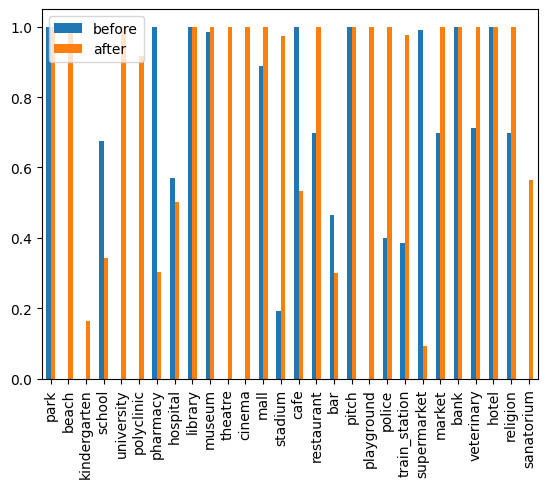

In [38]:
provisions_df = pd.DataFrame.from_dict({'before': prov_totals_before, 'after': prov_totals_after})
provisions_df.plot.bar()

# **Ф26**: Модуль ценностно-ориентированного моделирования программ развития населенного пункта.

Берем результат из пункта `2.b` и разворачиваем его на кварталы: куда что ставить:

- `block_id` -- номер квартала, куда ставим.
- `service_type` -- тип сервиса.
- `site_area` -- занимаемая площадь квартала.
- `build_floor_area` -- занимаемая площадь зданий.
- `capacity` -- суммарная емкость типа застройки
- `count` -- количество расставляемых объектов данного типа в данном квартале

In [39]:
solution_df = facade.solution_to_services_df(best_x)
solution_df

,block_id,service_type,site_area,build_floor_area,capacity,count
0,8,park,12000.0,0.0,270,1
5,13,park,12000.0,0.0,270,1
10,14,park,12000.0,0.0,270,1
15,15,park,12000.0,0.0,270,1
20,30,park,12000.0,0.0,270,1
...,...,...,...,...,...,...
2842,15,sanatorium,25000.0,7500.0,250,1
2845,30,sanatorium,25000.0,7500.0,250,1
2848,32,sanatorium,25000.0,7500.0,250,1
2851,36,sanatorium,25000.0,7500.0,250,1


Отсюда нужно взять `population` для каждого квартала (`index` здесь это тот же индекс из `blocks : pd.DataFrame`)

In [47]:
solution_population_df = facade.get_solution_area_df(best_x)
solution_population_df

,population,build_floor_area,living_area,footprint_area
0,0.0,40479.946439,0.00000,0.000000
1,0.0,604588.480444,0.00000,0.000000
2,0.0,164663.859830,0.00000,0.000000
3,12405.0,145414.649260,132912.64926,25851.493202
4,0.0,16.489152,0.00000,0.000000
...,...,...,...,...
2695,0.0,22875.011366,0.00000,0.000000
2696,0.0,1214.910251,0.00000,0.000000
2697,0.0,2449.592208,0.00000,0.000000
2698,0.0,5.073803,0.00000,0.000000


In [49]:
best_x

{'x_0': 12000,
 'x_1': 12000,
 'x_2': 12000,
 'x_3': 12000,
 'x_4': 12000,
 'x_5': 12000,
 'x_6': 12000,
 'x_7': 0,
 'x_8': 12000,
 'x_9': 1440,
 'x_10': 1440,
 'x_11': 1440,
 'x_12': 1440,
 'x_13': 1440,
 'x_14': 1440,
 'x_15': 1440,
 'x_16': 1440,
 'x_17': 1440,
 'x_18': 3520,
 'x_19': 3520,
 'x_20': 0,
 'x_21': 3520,
 'x_22': 3520,
 'x_23': 3520,
 'x_24': 3520,
 'x_25': 3520,
 'x_26': 3520,
 'x_27': 0,
 'x_28': 3520,
 'x_29': 3520,
 'x_30': 3520,
 'x_31': 0,
 'x_32': 0,
 'x_33': 0,
 'x_34': 0,
 'x_35': 18500,
 'x_36': 18500,
 'x_37': 0,
 'x_38': 18500,
 'x_39': 18500,
 'x_40': 18500,
 'x_41': 18500,
 'x_42': 18500,
 'x_43': 18500,
 'x_44': 0,
 'x_45': 18500,
 'x_46': 18500,
 'x_47': 18500,
 'x_48': 0,
 'x_49': 0,
 'x_50': 0,
 'x_51': 0,
 'x_52': 20000,
 'x_53': 30000,
 'x_54': 0,
 'x_55': 0,
 'x_56': 30000,
 'x_57': 30000,
 'x_58': 30000,
 'x_59': 30000,
 'x_60': 30000,
 'x_61': 20000,
 'x_62': 20000,
 'x_63': 30000,
 'x_64': 30000,
 'x_65': 20000,
 'x_66': 0,
 'x_67': 0,
 'x_68': 3

In [48]:
solution_population_df.loc[0]

population              0.000000
build_floor_area    40479.946439
living_area             0.000000
footprint_area          0.000000
Name: 0, dtype: float64

In [46]:
solution_df[solution_df.block_id == 0]

,block_id,service_type,site_area,build_floor_area,capacity,count
1845,0,police,700.0,240.0,60,1
2238,0,market,3000.0,6000.0,3000,1
2447,0,veterinary,0.0,95.0,17,1
